Name: Christina Wayman

email: christina@wayman.xyz

LinkedIn: www.linkedin.com/in/christinawayman/

# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Given a jobs listing dataset containing the columns below, this script aims to provide a predictive model and compare against a devised baseline from average of the dataset by industry.
    - Company ID
    - Job Type
    - Highest Degree
    - Major
    - Industry
    - Years of experience
    - Miles from the nearest Metropolis

The data are first examined, cleaned, and validated. Then distributions and correlations are shown by feature, where possible, alongside the target feature, salary, and some insight about what I've observed noted along the way. For the purpose of visualisation, average values per category are provided to observe the relationship between these features and salary. As an exploration of different types of dealing with categorical data, I have done one-hot encoded, mean encoded, and an experimental combination encoding of categorical features for use in our model. Suggested models from the observations in this dataset are linear model (with lasso or ridge regularisation), decision tree regression, and ensemble methods of random forest and XGboost.

In [108]:
#import libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
features_df = pd.read_csv('train_features.csv')
target_df = pd.read_csv('train_salaries.csv')
test_df = pd.read_csv('test_features.csv')

#### Examine each dataframe

In [3]:
display(features_df.head())
print(features_df.shape)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


(1000000, 8)


In [4]:
display(target_df.head())
print(target_df.shape)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


(1000000, 2)


In [5]:
display(test_df.head())
print(test_df.shape)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


(1000000, 8)


Since the layout of the test and features data are the same, no manipulation is required of the feature dataframes; additionally, the number of records in the target data is equal to those in the features dataframe.

In [6]:
train_df = pd.merge(target_df, features_df, on='jobId')
display(train_df.head())
print(train_df.shape)

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


(1000000, 9)


In [7]:
del features_df
del target_df

In [8]:
display(train_df.head())
print(train_df.shape)

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


(1000000, 9)


### ---- 3 Clean the data ----

In [9]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

#### Check for duplicates

In [10]:
train_df.duplicated().sum()
#train_df.drop_duplicates(inplace=True)

0

In [11]:
test_df.duplicated().sum()
#test_df.drop_duplicates(inplace=True)

0

There are no duplicates, so no need to drop duplicates

#### Check for missing data

In [12]:
train_df.isna().sum()

jobId                  0
salary                 0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

There are no missing values. No need to impute or otherwise address missing data

#### Check feature validity

In [13]:
#identifying columns with invalid features (ie, less than 0)
print("Features and number of invalid values: ")
for col in train_df.dtypes[train_df.dtypes != 'object'].index:
    temp = train_df[train_df[col] < 0].copy()
    print("The following jobIds have invalid data for " + col)
    display(temp)

Features and number of invalid values: 
The following jobIds have invalid data for salary


,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis


The following jobIds have invalid data for yearsExperience


,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis


The following jobIds have invalid data for milesFromMetropolis


,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis


Additionally, I shall check salary values less than 1, and remove any that are invalid:

In [14]:
display(train_df[train_df.salary < 1])
print(train_df.shape)

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
30559,JOB1362684438246,0,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7
495984,JOB1362684903671,0,COMP34,JUNIOR,NONE,NONE,OIL,1,25
652076,JOB1362685059763,0,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60
816129,JOB1362685223816,0,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6
828156,JOB1362685235843,0,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29


(1000000, 9)


In [15]:
train_df = train_df[train_df.salary > 0]
print(train_df.shape)
#final check to make sure the 5 invalid salaries have been removed

(999995, 9)


### ---- 4 Explore the data (EDA) ----

#### Look at data types and prepare for exploring features

In [16]:
train_df.dtypes

jobId                  object
salary                  int64
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object

In [17]:
#summary information about numerical variables
train_df.describe()

,salary,yearsExperience,milesFromMetropolis
count,999995.000000,999995.000000,999995.000000
mean,116.062398,11.992407,49.529381
std,38.717163,7.212390,28.877721
min,17.000000,0.000000,0.000000
25%,88.000000,6.000000,25.000000
50%,114.000000,12.000000,50.000000
75%,141.000000,18.000000,75.000000
max,301.000000,24.000000,99.000000


Numeric features to be explored are yearsExperience and milesFromMetropolis – salary will be examined further later, as the target variable.

In [18]:
numeric_cols = list(train_df.dtypes[train_df.dtypes != 'object'].index)
numeric_cols.remove('salary')
numeric_cols

['yearsExperience', 'milesFromMetropolis']

In [19]:
#summary information about categorical variables
train_df.describe(include=['object'])

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362684871466,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


jobID is a unique identifier, so this will not be a feature in the model dataset. I will only examine other categorical features to define the dataset.

In [20]:
categorical_cols = list(train_df.dtypes[train_df.dtypes == 'object'].index)
categorical_cols.remove('jobId')
categorical_cols

['companyId', 'jobType', 'degree', 'major', 'industry']

#### Explore each feature variable

##### Company ID
Initial thought is that CompanyID and Industry should be linked – perhaps companies belonging to certain industries might command higher salaries than others, and/or large international corporations compared with smaller ones? 63 companies is too many to run a countplot, but I will look at the range of counts per company:

In [21]:
train_df['companyId'].value_counts().sort_values()

COMP57    15635
COMP8     15638
COMP2     15641
COMP0     15666
COMP17    15715
          ...  
COMP3     16028
COMP30    16041
COMP59    16066
COMP35    16114
COMP39    16193
Name: companyId, Length: 63, dtype: int64

The number of employees per company ranges from 15635 - 16193. We can therefore conclude that all companies in our dataset are reasonably large organisations. Perhaps this will mean that the model we create will not be easily adapted for small or medium sized organizations.

In [22]:
train_df[['companyId','salary']].groupby(['companyId']).agg(np.mean)

,salary
companyId,
COMP0,115.963615
COMP1,116.048609
COMP10,116.019800
COMP11,116.113029
COMP12,116.086485
...,...
COMP61,116.318607
COMP62,116.279872
COMP7,115.888501


The CompanyId feature seems to have similar average salary, and similar distribution across the dataset. To confirm, we will plot the values in a boxplot.

In [23]:
def plot_boxplots(feature, target, data):
    '''
    :param feature: a heading from your Pandas dataframe corresponding to 
    an ordinal or categorical feature
    :type feature: str
    ...
    :param target: the heading from your Pandas dataframe corresponding to 
    a numerical target feature
    :type target: str
    ...
    :param data: variable of the Pandas dataframe containing target and features
    :type data: Pandas dataframe
    ...
    :return: None - shows the plot on screen
    :rtype: None
    '''
    plt.figure(figsize = (14, 6))
    sns.boxplot(x=feature, y=target, data=data)
    plt.xticks(rotation=45)
    plt.show()

In [30]:
def features(feature, feature_type, target, data, values=None):
    '''
    Given the name of a feature, and its type, will return a series of summary information
    and appropriate plots for EDA of your dataset
    :param feature: the name of a feature variable from your Pandas dataframe
    :type feature: str
    ...
    :param feature_type: the type of a feature variable from your Pandas dataframe
        the process will differ based on whether the feature is numerical ('num')
        or categorical ('cat')
    :type 'feature_type: str
    ...
    :param target: the name of your target variable from your Pandas dataframe
    :type target: str
    ...
    :param data: the variable name containing your Pandas dataframe
    :type data: Pandas dataframe
    ...
    :param values: the full or sampling range of your data. 
    Only used in feature_type = 'num'. Defaults to None.
    :type values: numpy.ndarray
    ...
    :return: None - only displays information on screen
    :rtype: None
    '''  
    if feature_type == 'num':
        #for numerical data type
        feature_selection = values
        sns.lineplot(x=feature, y=target, data=data)
    elif feature_type == 'cat':
        #for categorical data type
        feature_selection = data[feature].unique()
        if len(feature_selection) < 25:
            sns.countplot(y=feature, data=data) #companyID is too large for a countplot
            plt.show()
    while len(feature_selection) > 25:
        plot_feature = feature_selection[0:25] #selecting only the first 25 entries in the data
        first = True
        for value in plot_feature:
            if first:
                groups = data[[feature,target]][data[feature] == value]
                first = False
            group = data[[feature,target]][data[feature] == value]
            groups = pd.concat([groups, group], axis= 0)
        plot_boxplots(feature, target, groups)
        feature_selection = feature_selection[25:].copy() #reducing the data to remove the data just processed
    plot_feature = feature_selection[0:] #final set
    first = True
    for value in plot_feature:
        if first:
            groups = data[[feature,target]][data[feature] == value]
            first = False
        group = data[[feature,target]][data[feature] == value]
        groups = pd.concat([groups, group], axis= 0)
    plot_boxplots(feature,target, groups)
    display(groups.groupby([feature]).salary.describe()) #show summary table
    

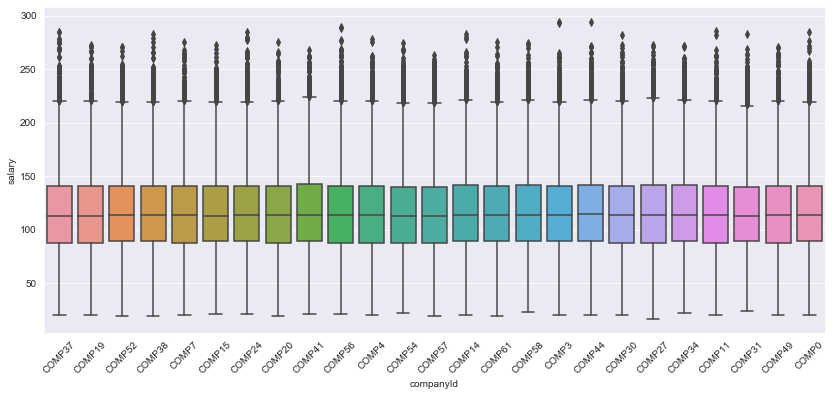

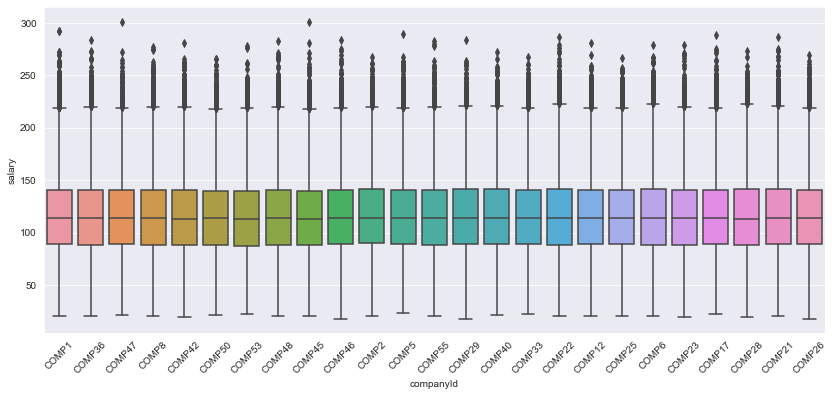

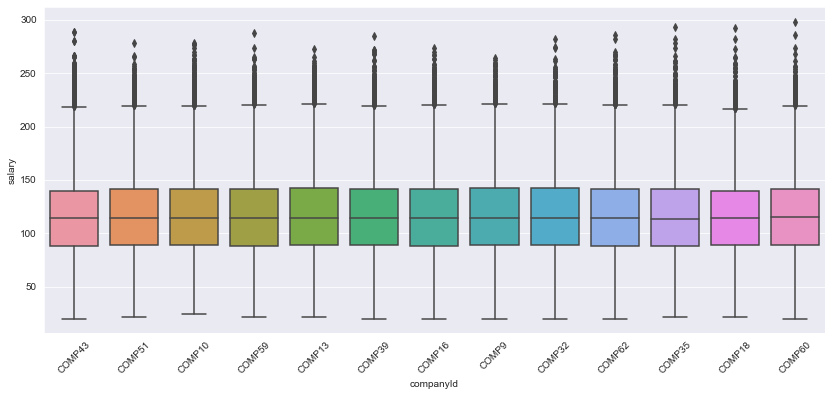

,count,mean,std,min,25%,50%,75%,max
companyId,,,,,,,,
COMP10,15909.0,116.019800,38.782127,24.0,89.0,114.0,141.0,278.0
COMP13,15956.0,116.561795,38.878367,21.0,89.0,114.0,142.0,273.0
COMP16,15783.0,116.358424,38.793806,20.0,88.0,114.0,141.0,274.0
COMP18,15957.0,115.597167,38.454768,21.0,89.0,114.0,140.0,292.0
COMP32,15958.0,115.974370,38.657629,20.0,89.0,114.0,142.0,282.0
COMP35,16114.0,115.774668,38.774082,21.0,88.0,113.0,141.0,293.0
COMP39,16193.0,116.087075,38.313617,20.0,89.0,114.0,141.0,285.0
COMP43,31910.0,115.800063,38.803008,20.0,88.0,114.0,140.0,289.0
COMP51,16005.0,116.290222,38.710174,21.0,89.0,114.0,141.0,278.0


In [25]:
features('companyId','cat','salary',train_df)

In [26]:
train_df[['companyId','industry','salary']].groupby(['companyId', 'industry']).salary.describe().sample(10)

,,count,mean,std,min,25%,50%,75%,max
companyId,industry,,,,,,,,
COMP34,OIL,2244.0,131.727718,39.436516,40.0,102.0,131.0,157.00,272.0
COMP52,FINANCE,2155.0,132.560093,37.857273,45.0,106.0,130.0,159.00,271.0
COMP42,WEB,2353.0,121.283893,37.942000,32.0,94.0,119.0,146.00,266.0
COMP54,EDUCATION,2239.0,99.360429,35.107228,22.0,75.0,98.0,122.00,230.0
COMP11,AUTO,2314.0,109.627917,35.776959,30.0,84.0,108.0,133.00,235.0
COMP35,AUTO,2289.0,109.558322,36.424462,27.0,84.0,108.0,133.00,229.0
COMP12,HEALTH,2240.0,114.683482,36.313118,33.0,89.0,113.0,138.00,234.0
COMP14,FINANCE,2230.0,131.198206,38.869283,44.0,104.0,129.0,156.75,261.0
COMP47,OIL,2232.0,131.596326,38.403186,42.0,105.0,128.0,158.00,301.0


Points to note about companyId:
   - Average salary, min and max, and standard deviation are similar across all companies. 
   - My suspicion about industry was incorrect – I had thought that the industry could pertain to the company, but it seemingly applies to the role, shown by COMP51 being repeated in the sample above (and across other companies I sampled, not shown).
   - There appear to be outliers across all companies – to further break down the outliers seen in the target variable, I will examine outliers by companyId

In [27]:
def identify_and_examine_outliers(feature):
    '''
    Identifies outliers (IQR * 1.5 from lower or upper quartiles) 
    within a given feature - returns the count of low outliers, high outliers, and the 
    percentage of the high outliers within the whole group.
    ...
    :param feature: the name of a feature variable from your Pandas dataframe
    :type feature: str
    ...
    :return: None - only displays information on screen
    :rtype: None
    '''
    print(feature, '\t\t', 'Low outliers', '\t', 'High outliers', '\t', '% outliers')
    if feature == 'salary':
            stat = train_df.salary.describe()
            IQR = stat['75%'] - stat['25%']
            upper = stat['75%'] + 1.5 * IQR
            lower = stat['25%'] - 1.5 * IQR
            print(feature, '\t\t\t', 
                  train_df.salary[train_df.salary < lower].count(), '\t\t',
                  train_df.salary[train_df.salary > upper].count(), '\t',
                 (train_df.salary[train_df.salary > upper].count() * 100 / train_df.salary.count()))
    else:
        stat = train_df[[feature,'salary']].groupby([feature]).salary.describe()
        IQR = stat['75%'] - stat['25%']
        upper = stat['75%'] + 1.5 * IQR
        lower = stat['25%'] - 1.5 * IQR
        for item in train_df[feature].unique():
            print(item, '\t\t\t', 
                  train_df.salary[(train_df[feature] == item) & 
                                  (train_df.salary < lower[item])].count(), '\t\t',
                 train_df.salary[(train_df[feature] == item) & 
                                  (train_df.salary > upper[item])].count(), '\t\t',
                 (train_df.salary[(train_df[feature] == item) & 
                                  (train_df.salary > upper[item])].count() * 100 / train_df.salary[train_df[feature] == item].count()))

In [28]:
identify_and_examine_outliers('companyId')

companyId 		 Low outliers 	 High outliers 	 % outliers
COMP37 			 0 		 107 		 0.6727444199937127
COMP19 			 0 		 101 		 0.6329113924050633
COMP52 			 0 		 120 		 0.7625341551757006
COMP38 			 0 		 132 		 0.8344395979518301
COMP7 			 0 		 109 		 0.6913173083021501
COMP15 			 0 		 108 		 0.67920256587636
COMP24 			 0 		 107 		 0.6758890783904996
COMP20 			 0 		 108 		 0.6788183532369579
COMP41 			 0 		 77 		 0.4855287218614036
COMP56 			 0 		 130 		 0.8135678077476688
COMP4 			 0 		 125 		 0.785274531976379
COMP54 			 0 		 138 		 0.8637416285910997
COMP57 			 0 		 108 		 0.6907579149344419
COMP14 			 0 		 106 		 0.666331405582097
COMP61 			 0 		 116 		 0.733156364555682
COMP58 			 0 		 113 		 0.7079756907461938
COMP3 			 0 		 121 		 0.754928874469678
COMP44 			 0 		 123 		 0.7685578605348663
COMP30 			 0 		 121 		 0.7543170625272738
COMP27 			 0 		 106 		 0.6720344893171876
COMP34 			 0 		 124 		 0.7843633373394902
COMP11 			 0 		 101 		 0.6363407258064516
COMP31 			 0 		 144 		 0.913937

Since all outliers are 0.5-1% of all company employees, over 63 companies, so this feature might contribute to the outliers in the target variable. We'll look into this some more when invetigating the target variable later on.

### Job type

There are 8 job types provided in this dataset: CEO, CTO, CFO, VICE_PRESIDENT, MANAGER, SENIOR, JUNIOR, and JANITOR. C-suite executives will command higher salaries than their more junior counterparts, so we expect to see this portrayed in these data.

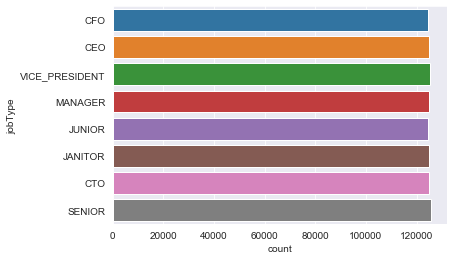

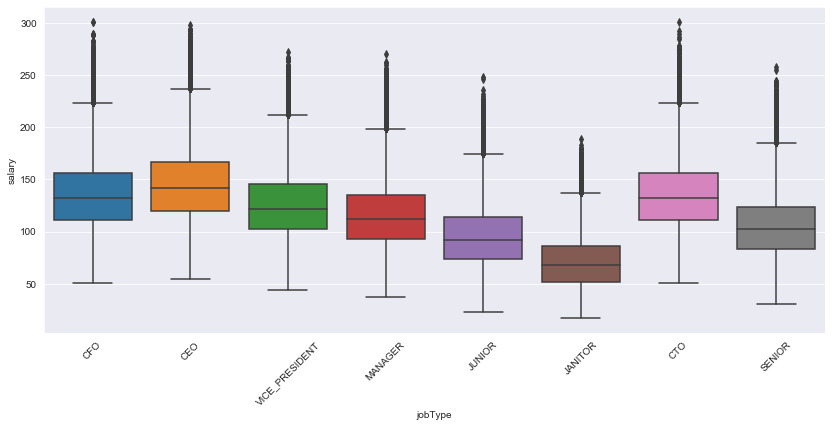

,count,mean,std,min,25%,50%,75%,max
jobType,,,,,,,,
CEO,124778.0,145.311425,34.423846,55.0,120.0,142.0,167.0,298.0
CFO,248738.0,135.458547,33.069137,51.0,111.0,132.0,156.0,301.0
CTO,125045.0,135.481067,33.090947,51.0,111.0,132.0,156.0,301.0
JANITOR,124971.0,70.813045,24.643021,17.0,52.0,68.0,86.0,189.0
JUNIOR,124592.0,95.333087,29.246759,23.0,74.0,92.0,114.0,248.0
MANAGER,125120.0,115.368518,30.833865,37.0,93.0,112.0,135.0,270.0
SENIOR,125886.0,105.487775,30.069722,31.0,83.0,102.0,124.0,258.0
VICE_PRESIDENT,125234.0,125.368630,31.956295,44.0,102.0,122.0,146.0,272.0


In [31]:
features('jobType', 'cat', 'salary', train_df, None)

In [32]:
identify_and_examine_outliers('jobType')

jobType 		 Low outliers 	 High outliers 	 % outliers
CFO 			 0 		 1234 		 0.9922086693629442
CEO 			 0 		 1134 		 0.9088140537594769
VICE_PRESIDENT 			 0 		 1074 		 0.857594582940735
MANAGER 			 0 		 1192 		 0.9526854219948849
JUNIOR 			 0 		 1285 		 1.0313663798638757
JANITOR 			 0 		 1365 		 1.092253402789447
CTO 			 0 		 1211 		 0.968451357511296
SENIOR 			 0 		 1330 		 1.0565114468646235


There appear to be some outliers in the Senior, Junior, and Janitor roles that need to be further investigated. Perhaps individuals applying for these roles have a wider range of available salaries depending on their experience and education than for more senior roles?

A thought for feature engineering – would separating into C-suite (CEO, CTO, CFO), Senior (VP, MANAGER), Mid-level(SENIOR, JUNIOR) and JANITOR be informative, or would ordinal labelling suffice (0 = JANITOR - 7 = CEO)? Or would mean encoding the variable be most useful?

In [33]:
train_df.groupby(['jobType', 'degree']).agg([np.mean, np.std])

salary            yearsExperience            \
                                  mean        std            mean       std   
jobType        degree                                                         
CEO            BACHELORS    148.421009  33.361200       12.002508  7.209675   
               DOCTORAL     158.232849  34.448793       12.001551  7.227637   
               HIGH_SCHOOL  135.629182  31.071963       12.006068  7.210640   
               MASTERS      153.254510  34.069260       11.992568  7.189323   
               NONE         130.796690  30.873326       11.988634  7.241517   
CFO            BACHELORS    138.508706  32.192597       11.991634  7.206442   
               DOCTORAL     148.308742  33.198258       11.951411  7.214436   
               HIGH_SCHOOL  125.964395  29.764747       11.987396  7.212928   
               MASTERS      143.316243  32.382933       11.999801  7.218632   
               NONE         121.135389  29.407701       12.021810  7.262770   
CTO            BACHELORS    138.363172  31.841512       11.991300  7.244813   
               DOCTORAL     148.269262  33.027200       11.999920  7.198437   
               HIGH_SCHOOL  126.082232  29.720179       12.001607  7.195336   
               MASTERS      143.582019  32.867804       11.982841  7.207408   
               NONE         120.939193  29.481474       12.079254  7.203216   
JANITOR        HIGH_SCHOOL   70.976821  24.706613       11.974498  7.219081   
               NONE          70.649575  24.578492       11.964825  7.204067   
JUNIOR         BACHELORS     98.130267  28.086700       11.968760  7.198961   
               DOCTORAL     108.356035  28.951452       11.991647  7.253500   
               HIGH_SCHOOL   85.791986  25.621652       11.983174  7.197517   
               MASTERS      103.463304  28.385453       12.012279  7.187316   
               NONE          80.884064  25.385195       12.006214  7.186412   
MANAGER        BACHELORS    118.173795  29.701521       11.954513  7.195049   
               DOCTORAL     128.211800  30.612943       11.998118  7.207633   
               HIGH_SCHOOL  106.068086  27.493503       12.014340  7.208562   
               MASTERS      123.389176  30.273772       11.971051  7.224278   
               NONE         100.981070  27.037940       11.998605  7.202755   
SENIOR         BACHELORS    108.325539  28.948472       12.020223  7.203083   
               DOCTORAL     118.867134  29.732624       12.074983  7.214769   
               HIGH_SCHOOL   95.908637  26.563009       12.016502  7.219094   
               MASTERS      113.408824  29.151642       11.954967  7.207399   
               NONE          90.628738  26.055192       11.915834  7.214111   
VICE_PRESIDENT BACHELORS    128.196227  31.003334       11.972855  7.269277   
               DOCTORAL     138.491400  31.772662       12.003606  7.185796   
               HIGH_SCHOOL  115.758343  28.681020       12.012261  7.211695   
               MASTERS      133.077062  31.336874       11.981932  7.191759   
               NONE         111.207654  28.247398       11.997664  7.217306   

                           milesFromMetropolis             
                                          mean        std  
jobType        degree                                      
CEO            BACHELORS             49.235760  28.831401  
               DOCTORAL              49.489123  28.865378  
               HIGH_SCHOOL           49.846527  28.979459  
               MASTERS               49.573219  28.941607  
               NONE                  49.252390  28.952217  
CFO            BACHELORS             49.483449  29.000281  
               DOCTORAL              49.807831  28.909401  
               HIGH_SCHOOL           49.381784  29.008106  
               MASTERS               49.528987  28.911509  
               NONE                  49.664805  28.797161  
CTO            BACHELORS             49.609810  28.857209  
               DOCTORAL        

The distribution appears to be pretty even across the job type feature. There appears to be a reasonable difference in salary between CEO and Janitor, with a cluster of outliers above the 3rd quartile of the box plot. The mean salary for a JUNIOR is 28 between NO education, and doctoral – this is the same range as for the CEO. Perhaps experience is more indicative?

##### Degree
There are 5 degrees in this category representing the minimum degree listed on the job application: DOCTORAL, MASTERS, BACHELORS, HIGH_SCHOOL, and NONE.

In general, more technical positions will need a degree (usually any degree, with higher degrees preferred); and this might be more prevalent in some roles than others (eg, in finance and engineering compared with customer service or janitorial roles). 

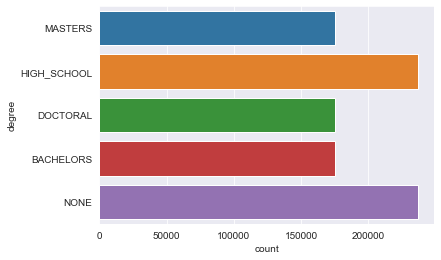

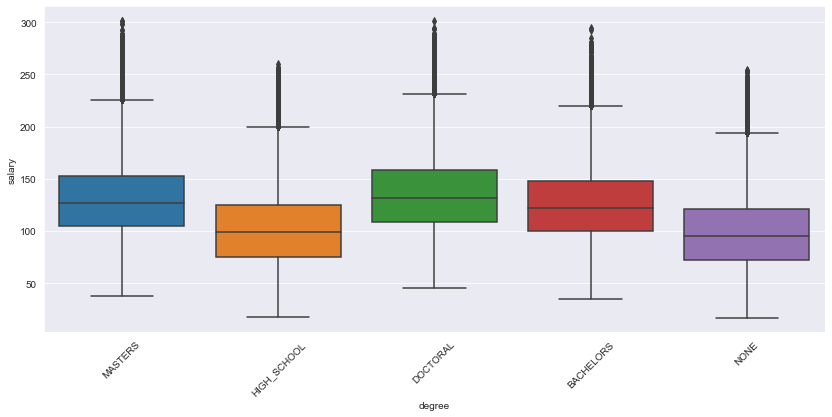

,count,mean,std,min,25%,50%,75%,max
degree,,,,,,,,
BACHELORS,175495.0,125.454663,35.042720,35.0,100.0,122.0,148.0,294.0
DOCTORAL,175362.0,135.490979,35.790555,45.0,109.0,132.0,158.0,301.0
HIGH_SCHOOL,236975.0,101.921085,36.112684,18.0,75.0,99.0,125.0,260.0
MASTERS,350620.0,130.505647,35.399780,38.0,105.0,127.0,153.0,301.0
NONE,236853.0,98.176882,34.915141,17.0,72.0,95.0,121.0,254.0


In [34]:
features('degree', 'cat', 'salary', train_df, None)

There appears to be a class imbalance between job listings that ask for specific degree and those that ask for high school or do not list a minimum education requirement. It is possible that some companies value experience over education, so the none might not be fully informative. Perhaps splitting into "asks for degree" and not, and then encoding types of degree could be more informative than the imbalance we see here:
- Degree: 526,167
- No Degree: 473,828

This feature would be quite indicative, with a further feature distinguishing the three degree types (which are also equally split) - again - do this with label encoding or mean encoding?

In [35]:
identify_and_examine_outliers('degree')

degree 		 Low outliers 	 High outliers 	 % outliers
MASTERS 			 0 		 1572 		 0.8966972791055844
HIGH_SCHOOL 			 0 		 1632 		 0.6886802405317016
DOCTORAL 			 0 		 1537 		 0.8764726679668343
BACHELORS 			 0 		 1440 		 0.8205361976124675
NONE 			 0 		 1724 		 0.727877628740189


### Majors
There are 9 majors listed within the job listings dataset: BIOLOGY, BUSINESS, CHEMISTRY, COMPSCI, ENGINEERING, LITERATURE, MATH, NONE, and PHYSICS.
Professional jobs, or those requiring technical know-how, might be more lucrative than those in other sectors – but then is it that the salary is linked to the major itself or the presence of one? I think it might be useful to distinguish between jobs that require any degree (Major = None, Bachelors-Doctorate = Yes), and those that require specific ones. For instance, positions in the finance industry are likely to require degrees in either business or math, but a role in education is likely to require a degree but not in any specific area.

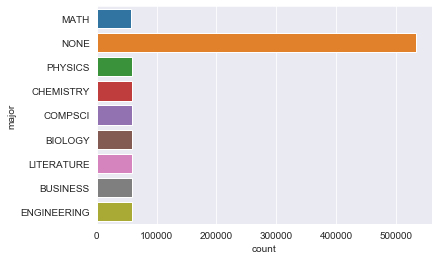

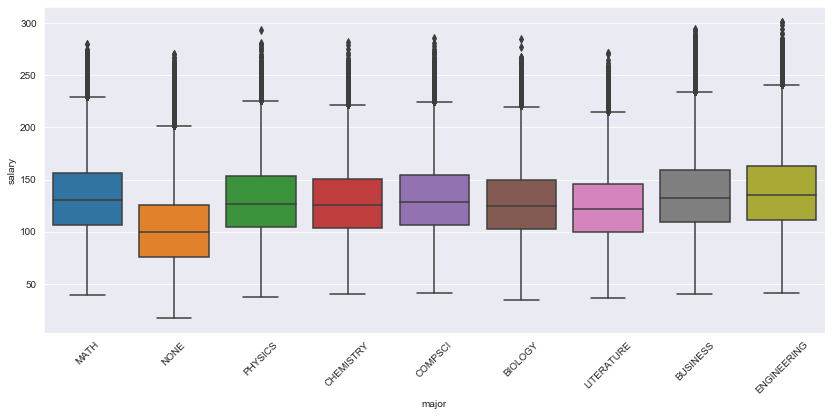

,count,mean,std,min,25%,50%,75%,max
major,,,,,,,,
BIOLOGY,58379.0,127.932664,34.820141,35.0,103.0,125.0,150.0,285.0
BUSINESS,58518.0,135.648980,37.006526,40.0,109.0,132.0,159.0,294.0
CHEMISTRY,58875.0,129.072085,34.832396,40.0,104.0,126.0,151.0,282.0
COMPSCI,58382.0,132.075605,34.776640,41.0,107.0,129.0,154.0,286.0
ENGINEERING,58594.0,138.441342,38.178934,41.0,111.0,135.0,163.0,301.0
LITERATURE,58684.0,124.423097,33.576413,37.0,100.0,122.0,146.0,271.0
MATH,115600.0,133.322042,35.539092,39.0,107.0,130.0,156.0,280.0
NONE,532353.0,102.583864,36.136268,17.0,76.0,100.0,126.0,270.0
PHYSICS,58410.0,130.372436,34.956981,38.0,105.0,127.0,153.0,293.0


In [36]:
features('major', 'cat', 'salary', train_df, None)

We can easily identify a large class imbalance in this subset of data. From the summary table, we can see that job listings that do not have a major requirement demand 20-40 less than listings that have a major requirement. 
During feature engineering, I suggest splitting into 3 categories:
    - Specific degree required (technical roles) (n = 467,642)
    - Any degree required (professional roles) n=?
    - No degree required (manual/unskilled roles) (n=? currently - 532,353)
    
I will look into this feature more later, but if option 2 is a bust, then I think having a label or mean encoding of sets 1 and 3 will reduce the class imbalance substantially.

In [37]:
identify_and_examine_outliers('major')

major 		 Low outliers 	 High outliers 	 % outliers
MATH 			 0 		 470 		 0.8131487889273357
NONE 			 0 		 3760 		 0.7062982644974294
PHYSICS 			 0 		 462 		 0.7909604519774012
CHEMISTRY 			 0 		 525 		 0.89171974522293
COMPSCI 			 0 		 532 		 0.9112397656812031
BIOLOGY 			 0 		 522 		 0.8941571455489131
LITERATURE 			 0 		 468 		 0.7974916501942608
BUSINESS 			 0 		 518 		 0.8851977169417957
ENGINEERING 			 0 		 468 		 0.7987165921425402


The NONE major type has a large number of outliers, but in proportion with the outliers seen in other groups in this subset.

##### Industry
At first I understood industry to be related to the company, but it appears now to be related to specific roles within a company. There are 7 types in this dataset: AUTO, EDUCATION, FINANCE, HEALTH, OIL, SERVICE, and WEB.

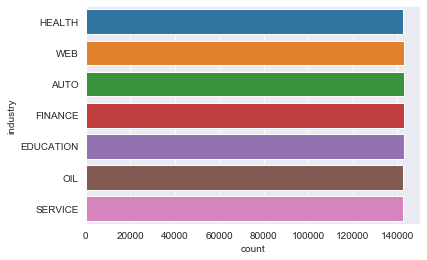

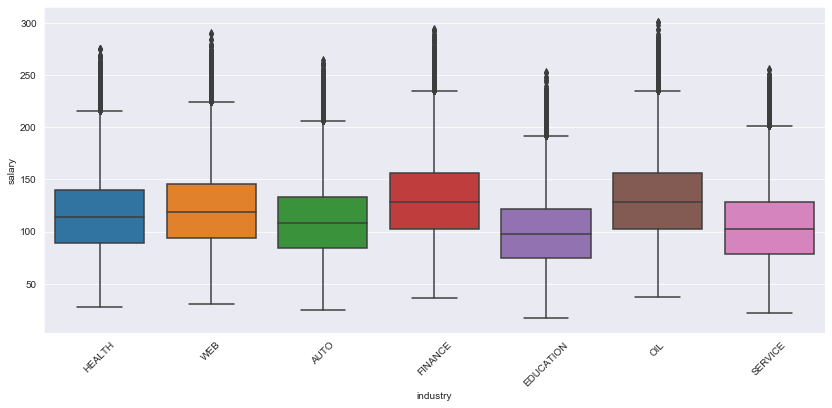

,count,mean,std,min,25%,50%,75%,max
industry,,,,,,,,
AUTO,142941.0,109.435222,36.091590,25.0,84.0,108.0,133.0,264.0
EDUCATION,142819.0,99.448386,35.110257,17.0,75.0,98.0,122.0,253.0
FINANCE,142866.0,130.747659,38.319820,36.0,103.0,128.0,156.0,294.0
HEALTH,285510.0,115.735540,36.865115,28.0,89.0,114.0,140.0,275.0
OIL,142770.0,130.953863,38.528558,37.0,103.0,128.0,156.0,301.0
SERVICE,142639.0,104.446820,35.577606,22.0,79.0,103.0,128.0,256.0
WEB,143205.0,121.645362,38.165659,31.0,94.0,119.0,146.0,290.0


In [38]:
features('industry', 'cat', 'salary', train_df, None)

EDUCATION and SERVICE roles command lower wages compared with FINANCE, OIL, and WEB, which is to be expected. I don't particularly expect there to be a relationship between the different industries, since we've identified that each company has roles spanning several industries.

For instance, a Web Services company would have personnel in the Web (or engineering) department, in Service (customer service, janitorial staff), and in finance. Would the "Industry" of the CEO be informative as a proxy for the industry of the company? Or identifying the industry of most employees per company?

In [39]:
train_df[(train_df['jobType'] == 'CEO') & (train_df['companyId'] == 'COMP11')]

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
43,JOB1362684407730,106,COMP11,CEO,NONE,NONE,FINANCE,2,38
82,JOB1362684407769,176,COMP11,CEO,DOCTORAL,MATH,WEB,10,73
2445,JOB1362684410132,114,COMP11,CEO,HIGH_SCHOOL,NONE,EDUCATION,11,45
2693,JOB1362684410380,168,COMP11,CEO,BACHELORS,LITERATURE,WEB,16,19
3021,JOB1362684410708,140,COMP11,CEO,BACHELORS,NONE,WEB,19,55
...,...,...,...,...,...,...,...,...,...
998675,JOB1362685406362,101,COMP11,CEO,BACHELORS,ENGINEERING,EDUCATION,1,23
998846,JOB1362685406533,100,COMP11,CEO,NONE,NONE,AUTO,16,47
998915,JOB1362685406602,123,COMP11,CEO,DOCTORAL,BIOLOGY,EDUCATION,6,77
999450,JOB1362685407137,97,COMP11,CEO,MASTERS,LITERATURE,EDUCATION,9,89


Well, that's a non-starter – there seem to be 1997 listings for CEOs at COMP11 in this dataset! This is troubling!! Perhaps seeing what the "main" industry per company?

In [40]:
train_df[train_df['companyId'] == 'COMP11'].groupby('industry').jobId.count()

industry
AUTO         2314
EDUCATION    2274
FINANCE      2258
HEALTH       2318
OIL          2197
SERVICE      2214
WEB          2297
Name: jobId, dtype: int64

And a similar dead end with the "main" industry per company idea. Let's just check outliers:

In [41]:
identify_and_examine_outliers('industry')

industry 		 Low outliers 	 High outliers 	 % outliers
HEALTH 			 0 		 830 		 0.5814157122342475
WEB 			 0 		 1024 		 0.7150588317447016
AUTO 			 0 		 916 		 0.6408238364080285
FINANCE 			 0 		 867 		 0.6068623745327789
EDUCATION 			 0 		 1070 		 0.7492000364097214
OIL 			 0 		 940 		 0.6584016249912447
SERVICE 			 0 		 859 		 0.6022195893128808


The proportion of outliers is quite low in this subset of data.

### Years Experience

This is the first of our numerical features, which spans 0-24 years. I would expect this relationship to be approximately linear, with pay increasing with more years experience. Instead of plotting all values on the boxplot, I will sample every 3 years to follow any potential trend.

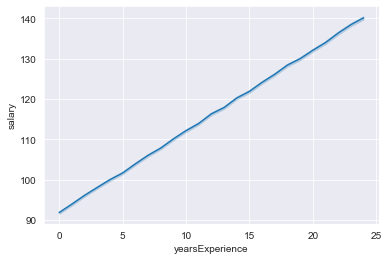

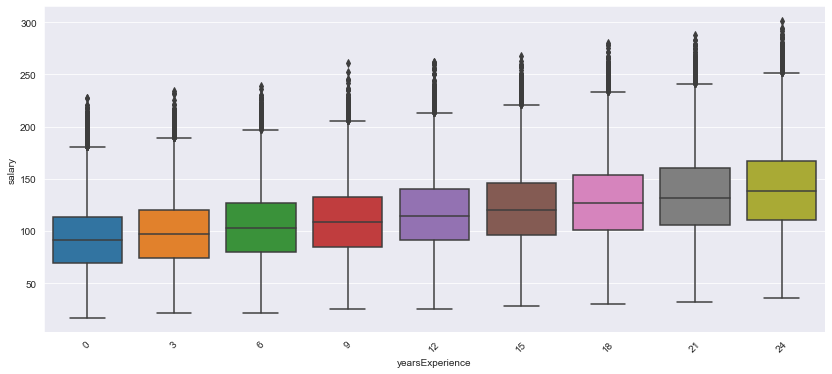

,count,mean,std,min,25%,50%,75%,max
yearsExperience,,,,,,,,
0,79678.0,91.873541,32.383322,17.0,69.0,91.0,113.75,227.0
3,40190.0,98.092809,33.026186,21.0,74.0,97.0,120.00,234.0
6,40094.0,103.924278,33.708699,21.0,80.0,103.0,127.00,239.0
9,40235.0,110.106375,34.493873,25.0,85.0,109.0,133.00,261.0
12,39467.0,116.342387,35.494535,25.0,91.0,114.0,140.00,262.0
15,40312.0,121.903850,36.667844,28.0,96.0,120.0,146.00,268.0
18,40088.0,128.431102,37.857690,30.0,101.0,127.0,154.00,280.0
21,39759.0,134.002415,38.903731,32.0,106.0,132.0,160.00,288.0
24,39860.0,140.131109,40.101014,36.0,111.0,138.0,167.00,301.0


In [42]:
years = np.arange(0,24+1, 3)
features('yearsExperience', 'num', 'salary', train_df, years)

From the above linear plot, we can see that the relationship is approximately 
y = 2x + 90. It is ultimately likely to be independent from other features.

In [43]:
identify_and_examine_outliers('yearsExperience')

yearsExperience 		 Low outliers 	 High outliers 	 % outliers
10 			 0 		 185 		 0.46213029576338926
3 			 0 		 199 		 0.49514804677780544
8 			 0 		 164 		 0.40879405753028564
2 			 0 		 152 		 0.37957298039705334
23 			 0 		 194 		 0.4848181931775584
9 			 0 		 145 		 0.3603827513359016
1 			 0 		 170 		 0.4222133916153388
17 			 0 		 214 		 0.5340387302854861
24 			 0 		 179 		 0.4490717511289513
7 			 0 		 176 		 0.4394836067620546
21 			 0 		 169 		 0.42506099247969015
13 			 0 		 170 		 0.42685682719831264
11 			 0 		 194 		 0.485631320716932
14 			 0 		 178 		 0.44693298516082053
18 			 0 		 166 		 0.41408900419078026
20 			 0 		 209 		 0.5226567970391117
12 			 0 		 182 		 0.46114475384498443
15 			 0 		 203 		 0.5035721373288351
22 			 0 		 217 		 0.5399756140045289
0 			 0 		 167 		 0.4191872285950953
19 			 0 		 185 		 0.4641244355243352
5 			 0 		 201 		 0.5023367405593182
4 			 0 		 174 		 0.4346088520331701
16 			 0 		 183 		 0.45895718907531413
6 			 0 		 165 		 0.4115328

There are a small proportion of outliers in this set (0.5% or less), so this subset is unlikely to be a major contributor to overall outliers in the dataset.

#### Miles from metropolis
This feature is a little less intuitive – at first, I expected that each company would be the same number of miles from a city center – but on second look, the variation in this distance was too high within companies and too evenly distributed: 

In [44]:
train_df[['companyId','milesFromMetropolis']].groupby(['companyId']).milesFromMetropolis.describe().sample(10)

,count,mean,std,min,25%,50%,75%,max
companyId,,,,,,,,
COMP59,16066.0,49.550106,28.718998,0.0,25.0,50.0,74.0,99.0
COMP42,15943.0,49.936210,28.836483,0.0,25.0,50.0,75.0,99.0
COMP18,15957.0,49.408410,28.913957,0.0,24.0,49.0,75.0,99.0
COMP7,15767.0,49.624152,28.877330,0.0,25.0,49.0,75.0,99.0
COMP9,15988.0,49.203277,28.792917,0.0,24.0,49.0,74.0,99.0
COMP62,15943.0,49.491877,29.040389,0.0,24.0,50.0,75.0,99.0
COMP40,16007.0,49.205223,28.870945,0.0,24.0,49.0,74.0,99.0
COMP50,15791.0,49.874106,28.970090,0.0,25.0,50.0,75.0,99.0
COMP2,15641.0,49.782814,28.756153,0.0,25.0,50.0,74.0,99.0


Perhaps headquarters are in the city, and more manual roles (perhaps at a car plant, or customer support center), are further out of larger cities to save on rental costs for companies needing larger spaces?

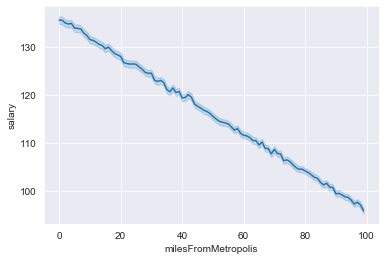

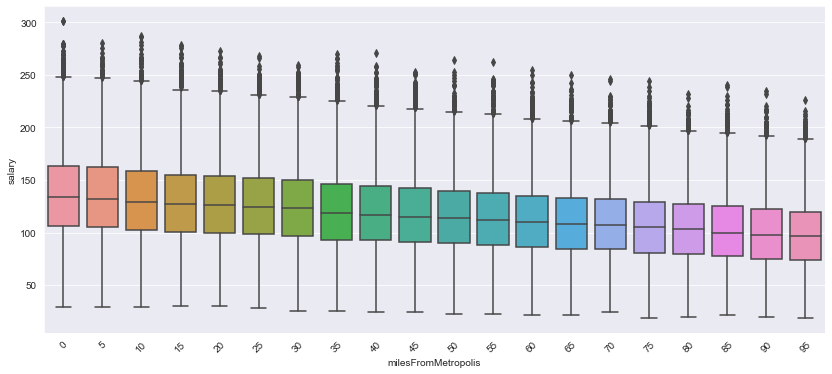

,count,mean,std,min,25%,50%,75%,max
milesFromMetropolis,,,,,,,,
0,20246.0,135.571175,41.095954,29.0,106.0,134.0,163.0,301.0
5,9955.0,133.888800,41.036924,29.0,105.0,132.0,162.0,280.0
10,10048.0,131.490048,40.910063,29.0,102.0,129.0,159.0,287.0
15,9927.0,129.568550,39.708363,30.0,101.0,127.0,155.0,278.0
20,9807.0,127.980728,39.711289,30.0,100.0,126.0,154.0,273.0
25,10003.0,126.344497,38.848234,28.0,99.0,124.0,152.0,268.0
30,10078.0,124.486505,38.605479,25.0,97.0,123.0,150.0,259.0
35,9928.0,121.099819,38.120073,25.0,93.0,119.0,146.0,270.0
40,9966.0,119.352398,37.435740,24.0,93.0,117.0,144.0,271.0


In [45]:
miles = np.arange(0, 99+1, 5)
features('milesFromMetropolis', 'num', 'salary', train_df, miles)

As we can see from the linear plot above, the distance from a city seems to be negatively linearly correlated with salary with an approximate formula of y = -2x + 140

### Salary

#### Explore the target variable

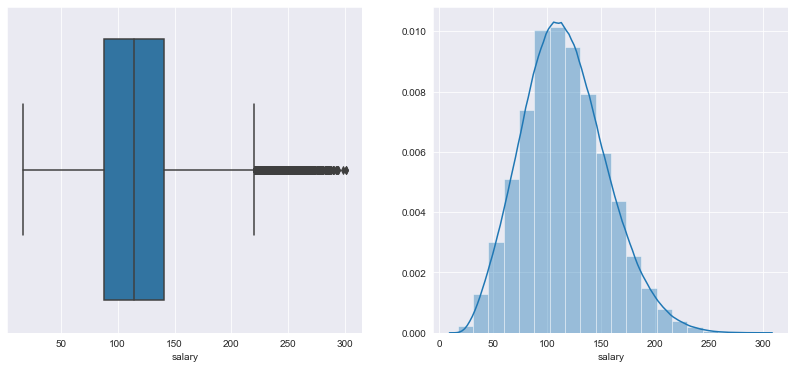

In [46]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(train_df.salary)
plt.subplot(1,2,2)
sns.distplot(train_df.salary, bins=20)
plt.show()

Salary appears to be normally distributed with a small skew to the right. We have been identifying outliers in each of the feature variables, but perhaps a dive into the outliers in this set might be worth pursuing:

In [47]:
display(train_df.salary.describe())
identify_and_examine_outliers('salary')

count    999995.000000
mean        116.062398
std          38.717163
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64

salary 		 Low outliers 	 High outliers 	 % outliers
salary 			 0 		 7117 	 0.7117035585177925


Some substantial numbers of outliers in the dataset here - I wonder if we can identify outliers by subgroup:

In [48]:
IQR = train_df.salary.quantile(0.75) - train_df.salary.quantile(0.25)
upper_bound = train_df.salary.quantile(0.75) + (1.5 * IQR)
for item in categorical_cols:
    print(f'Outliers of the whole dataset broken down by {item}')
    display(train_df.loc[train_df.salary > upper_bound, item].value_counts())
for item in numeric_cols:
    print(f'Outliers of the whole dataset broken down by {item}')
    display(train_df.loc[train_df.salary > upper_bound, item].value_counts())

Outliers of the whole dataset broken down by companyId


COMP10    138
COMP8     135
COMP34    134
COMP59    132
COMP44    130
         ... 
COMP47     96
COMP28     96
COMP60     95
COMP18     94
COMP29     90
Name: companyId, Length: 63, dtype: int64

Outliers of the whole dataset broken down by jobType


CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

Outliers of the whole dataset broken down by degree


DOCTORAL       2981
MASTERS        2134
BACHELORS      1440
HIGH_SCHOOL     354
NONE            208
Name: degree, dtype: int64

Outliers of the whole dataset broken down by major


ENGINEERING    1488
BUSINESS       1162
NONE            882
MATH            816
COMPSCI         702
PHYSICS         631
CHEMISTRY       569
BIOLOGY         522
LITERATURE      345
Name: major, dtype: int64

Outliers of the whole dataset broken down by industry


OIL          2368
FINANCE      2200
WEB          1280
HEALTH        631
AUTO          325
SERVICE       200
EDUCATION     113
Name: industry, dtype: int64

Outliers of the whole dataset broken down by yearsExperience


24    1227
23    1084
22     923
21     734
20     648
19     488
18     453
17     369
16     276
15     223
14     166
13     140
12     103
11      90
10      49
8       37
9       37
7       22
6       15
5       13
4        7
3        6
2        3
1        2
0        2
Name: yearsExperience, dtype: int64

Outliers of the whole dataset broken down by milesFromMetropolis


1     277
0     266
4     253
2     252
3     244
     ... 
90      2
94      2
84      1
98      1
95      1
Name: milesFromMetropolis, Length: 97, dtype: int64

To check the most suspicious outliers above the upper bound, I will check the following entries:
    - Junior roles with outlier salaries
    - degree or major = None with outlier salaries
    - years experience = 0 with outlier salaries
    - education and service with outlier salaries

In [49]:
# investigate most suspicious potential outliers above upper bound
train_df[(train_df.salary > upper_bound) & (train_df.jobType == 'JUNIOR')]

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
1222,JOB1362684408909,225,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5
27710,JOB1362684435397,246,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3
31355,JOB1362684439042,225,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0
100042,JOB1362684507729,248,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8
160333,JOB1362684568020,223,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3
189582,JOB1362684597269,221,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11
214606,JOB1362684622293,222,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4
303778,JOB1362684711465,226,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2
348354,JOB1362684756041,226,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25
427593,JOB1362684835280,221,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3


Most of these Junior roles require either a Bachelor's-Doctorate degree, in oil, finance, or web industry, with >18 years experience (arguably though, this is not a junior role!). 


In [50]:
# investigate most suspicious potential outliers above upper bound
train_df[(train_df.salary > upper_bound) & (train_df.degree == 'NONE')].sample(25)

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
451747,JOB1362684859434,223,COMP26,CTO,NONE,NONE,OIL,24,20
700024,JOB1362685107711,231,COMP48,CFO,NONE,NONE,OIL,20,13
683366,JOB1362685091053,238,COMP16,CFO,NONE,NONE,FINANCE,24,3
438834,JOB1362684846521,230,COMP29,CFO,NONE,NONE,OIL,24,9
405847,JOB1362684813534,244,COMP3,CEO,NONE,NONE,OIL,21,12
13160,JOB1362684420847,224,COMP24,CEO,NONE,NONE,FINANCE,20,11
197852,JOB1362684605539,232,COMP31,CFO,NONE,NONE,FINANCE,24,7
279993,JOB1362684687680,226,COMP30,CEO,NONE,NONE,WEB,19,5
904282,JOB1362685311969,253,COMP21,CEO,NONE,NONE,FINANCE,23,1
515372,JOB1362684923059,224,COMP33,VICE_PRESIDENT,NONE,NONE,FINANCE,24,5


No degree with outliers appears to refer to C-suite executives in the Oil, Web, and Finance industries with more than 14 years experience.

In [51]:
# investigate most suspicious potential outliers above upper bound
train_df[(train_df.salary > upper_bound) & (train_df.major == 'NONE')].sample(25)

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
946692,JOB1362685354379,225,COMP42,CEO,HIGH_SCHOOL,NONE,OIL,24,16
772326,JOB1362685180013,229,COMP31,CTO,HIGH_SCHOOL,NONE,FINANCE,24,14
86672,JOB1362684494359,222,COMP13,CEO,DOCTORAL,NONE,OIL,18,28
489583,JOB1362684897270,228,COMP0,CEO,NONE,NONE,FINANCE,20,34
560070,JOB1362684967757,224,COMP60,CFO,HIGH_SCHOOL,NONE,FINANCE,23,30
908215,JOB1362685315902,253,COMP13,CFO,HIGH_SCHOOL,NONE,FINANCE,24,6
575916,JOB1362684983603,228,COMP60,CTO,DOCTORAL,NONE,OIL,14,9
410933,JOB1362684818620,229,COMP18,CFO,HIGH_SCHOOL,NONE,FINANCE,24,2
400887,JOB1362684808574,248,COMP31,CEO,MASTERS,NONE,HEALTH,22,13
52362,JOB1362684460049,245,COMP34,CEO,HIGH_SCHOOL,NONE,FINANCE,24,10


This category is more of a mix than previous (degree=None) -- There are a range of degree types, but still mostly C-suite executives in the Finance, Oil, Web, and Auto industries. Again with largely >15 years experience.

In [52]:
# investigate most suspicious potential outliers above upper bound
display(train_df[(train_df.salary > upper_bound) & (train_df.industry == ('EDUCATION'))].sample(25))
display(train_df[(train_df.salary > upper_bound) & (train_df.industry == ('SERVICE'))].sample(25))

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
679986,JOB1362685087673,222,COMP10,CEO,MASTERS,NONE,EDUCATION,21,7
867816,JOB1362685275503,229,COMP29,CTO,DOCTORAL,BUSINESS,EDUCATION,21,10
54981,JOB1362684462668,233,COMP23,CEO,DOCTORAL,PHYSICS,EDUCATION,23,16
262370,JOB1362684670057,224,COMP29,CEO,DOCTORAL,NONE,EDUCATION,23,8
368317,JOB1362684776004,222,COMP38,CFO,MASTERS,PHYSICS,EDUCATION,22,19
818688,JOB1362685226375,230,COMP13,CTO,DOCTORAL,MATH,EDUCATION,24,12
900810,JOB1362685308497,223,COMP60,CEO,DOCTORAL,MATH,EDUCATION,16,0
969434,JOB1362685377121,229,COMP50,CFO,DOCTORAL,ENGINEERING,EDUCATION,22,3
69194,JOB1362684476881,236,COMP1,CEO,DOCTORAL,BUSINESS,EDUCATION,22,23
606190,JOB1362685013877,223,COMP62,CTO,DOCTORAL,LITERATURE,EDUCATION,21,16


,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
419729,JOB1362684827416,228,COMP2,CEO,DOCTORAL,BUSINESS,SERVICE,24,59
150849,JOB1362684558536,226,COMP41,CEO,MASTERS,BIOLOGY,SERVICE,19,4
677908,JOB1362685085595,233,COMP35,CEO,BACHELORS,BUSINESS,SERVICE,23,1
402132,JOB1362684809819,228,COMP59,CFO,DOCTORAL,CHEMISTRY,SERVICE,21,2
119057,JOB1362684526744,226,COMP40,CFO,DOCTORAL,MATH,SERVICE,24,18
236203,JOB1362684643890,225,COMP37,CTO,MASTERS,BUSINESS,SERVICE,20,4
439357,JOB1362684847044,223,COMP0,CTO,MASTERS,COMPSCI,SERVICE,21,1
702877,JOB1362685110564,225,COMP33,CEO,BACHELORS,ENGINEERING,SERVICE,20,3
356157,JOB1362684763844,222,COMP52,CEO,DOCTORAL,PHYSICS,SERVICE,16,31
295471,JOB1362684703158,229,COMP9,CTO,DOCTORAL,PHYSICS,SERVICE,23,8


In Education and Service industries, C-suite executives with degrees (in any field), and > 20 years experience seem to be responsible for higher salaries

My takeaway from looking at all these outliers in the sample category is that the features jobType, degree, major, and industry are likely to be correlated features. I'll take a look at this further in the next section. 

First, I will need to encode my categorical variables. I'm not yet clear on the value of using label encoding versus mean encoding versus one-hot encoding, so I'd like to create three tables to experiment on which performs better. I'll create three base tables (one label_abt, one mean_abt, one oh_abt) so that I can test them in the modelling stage.
However, perhaps if I try to apply a combination - label encoding for clear ordinal values (like degree), mean encoding or one-hot encoding for non-ordinal (like industry, or companyID). Perhaps mean encoding might be better for companyId, which would consume too many columns if one-hot encoded? I'll create one final table using this strategy - experimental_abt.

I'll then use a correlation matrix of each abt to determine a) whether there is correlation between features, and b) correlation with the target variable.

### Encoding categorical variables

In [53]:
#one-hot encoded base table
oh_abt = pd.get_dummies(train_df, drop_first=True, columns=categorical_cols)

In [54]:
oh_abt.head()

,jobId,salary,yearsExperience,milesFromMetropolis,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,companyId_COMP18,companyId_COMP19,companyId_COMP2,companyId_COMP20,companyId_COMP21,companyId_COMP22,companyId_COMP23,companyId_COMP24,companyId_COMP25,companyId_COMP26,companyId_COMP27,companyId_COMP28,companyId_COMP29,companyId_COMP3,companyId_COMP30,companyId_COMP31,companyId_COMP32,companyId_COMP33,companyId_COMP34,companyId_COMP35,companyId_COMP36,companyId_COMP37,companyId_COMP38,companyId_COMP39,companyId_COMP4,companyId_COMP40,companyId_COMP41,companyId_COMP42,companyId_COMP43,companyId_COMP44,companyId_COMP45,companyId_COMP46,companyId_COMP47,companyId_COMP48,companyId_COMP49,companyId_COMP5,companyId_COMP50,companyId_COMP51,companyId_COMP52,companyId_COMP53,companyId_COMP54,companyId_COMP55,companyId_COMP56,companyId_COMP57,companyId_COMP58,companyId_COMP59,companyId_COMP6,companyId_COMP60,companyId_COMP61,companyId_COMP62,companyId_COMP7,companyId_COMP8,companyId_COMP9,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,degree_HIGH_SCHOOL,degree_MASTERS,degree_NONE,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,JOB1362684407687,130,10,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,JOB1362684407688,101,3,73,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,JOB1362684407689,137,10,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,JOB1362684407690,142,8,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,JOB1362684407691,163,8,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [70]:
def mean_encode(df, col):
    cat_dict = {}
    cats = set(train_df[col].to_list())
    for cat in cats:
        cat_dict[cat] = train_df[train_df[col] == cat]['salary'].mean()
    df[col] = df[col].map(cat_dict)

In [71]:
#mean-encoded base table
mean_abt = train_df.copy()
for col in categorical_cols: 
    mean_encode(mean_abt, col)
mean_abt.head()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,130,115.345049,135.458547,130.505647,133.322042,115.735540,10,83
1,JOB1362684407688,101,115.756548,145.311425,101.921085,102.583864,121.645362,3,73
2,JOB1362684407689,137,116.224249,125.368630,135.490979,130.372436,115.735540,10,38
3,JOB1362684407690,142,116.199380,115.368518,135.490979,129.072085,109.435222,8,17
4,JOB1362684407691,163,115.888501,125.368630,125.454663,130.372436,130.747659,8,16


In [104]:
def label_encode(df, col):
    cat_dict = {}
    label = 0
    cats = set(train_df[col].to_list())
    if col == 'degree':
        cats = ['NONE', 'HIGH_SCHOOL', 'BACHELORS', 'MASTERS', 'DOCTORAL']
    if col == 'jobType':
        cats == ['JANITOR', 'JUNIOR', 'SENIOR', 'MANAGER', 'VICE_PRESIDENT', 'CFO', 'CTO', 'CEO']
    if col == 'industry':
        cats = ['EDUCATION', 'SERVICE', 'AUTO', 'HEALTH', 'WEB', 'FINANCE', 'OIL']
    if col == 'major':
        cats == ['NONE', 'LITERATURE', 'BIOLOGY', 'CHEMISTRY', 'PHYSICS', 'COMPSCI', 'MATH', 'BUSINESS', 'ENGINEERING']
    for cat in cats:
        cat_dict[cat] = label
        label += 1
    df[col] = df[col].map(cat_dict)

In [105]:
label_abt = train_df.copy()
for col in categorical_cols:
    label_encode(label_abt, col)
label_abt.head()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,130,3,2,3,6,3,10,83
1,JOB1362684407688,101,19,5,1,1,4,3,73
2,JOB1362684407689,137,40,6,4,2,3,10,38
3,JOB1362684407690,142,58,4,4,8,2,8,17
4,JOB1362684407691,163,56,6,2,2,5,8,16


As mentioned above, my experimental_abt will have a combination of encoding methods – ordinal for the degree and jobType variables, one_hot_encoding for major and industry, and mean encoding for companyId

In [74]:
experimental_abt = pd.get_dummies(train_df, drop_first=True, columns=['major', 'industry'])
mean_encode(experimental_abt, 'companyId')
for col in ['degree', 'jobType']:
    label_encode(experimental_abt, col)
experimental_abt.head()

,jobId,salary,companyId,jobType,degree,yearsExperience,milesFromMetropolis,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,JOB1362684407687,130,115.345049,2,3,10,83,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,JOB1362684407688,101,115.756548,5,1,3,73,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,JOB1362684407689,137,116.224249,6,4,10,38,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,JOB1362684407690,142,116.199380,4,4,8,17,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,JOB1362684407691,163,115.888501,6,2,8,16,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [75]:
for abt in [oh_abt, mean_abt, label_abt, experimental_abt]:
    print(abt.dtypes)

jobId                  object
salary                  int64
yearsExperience         int64
milesFromMetropolis     int64
companyId_COMP1         uint8
                        ...  
industry_FINANCE        uint8
industry_HEALTH         uint8
industry_OIL            uint8
industry_SERVICE        uint8
industry_WEB            uint8
Length: 91, dtype: object
jobId                   object
salary                   int64
companyId              float64
jobType                float64
degree                 float64
major                  float64
industry               float64
yearsExperience          int64
milesFromMetropolis      int64
dtype: object
jobId                  object
salary                  int64
companyId               int64
jobType                 int64
degree                  int64
major                   int64
industry                int64
yearsExperience         int64
milesFromMetropolis     int64
dtype: object
jobId                   object
salary                   int64
compa

### Correlations

#### One-hot encoding abt 

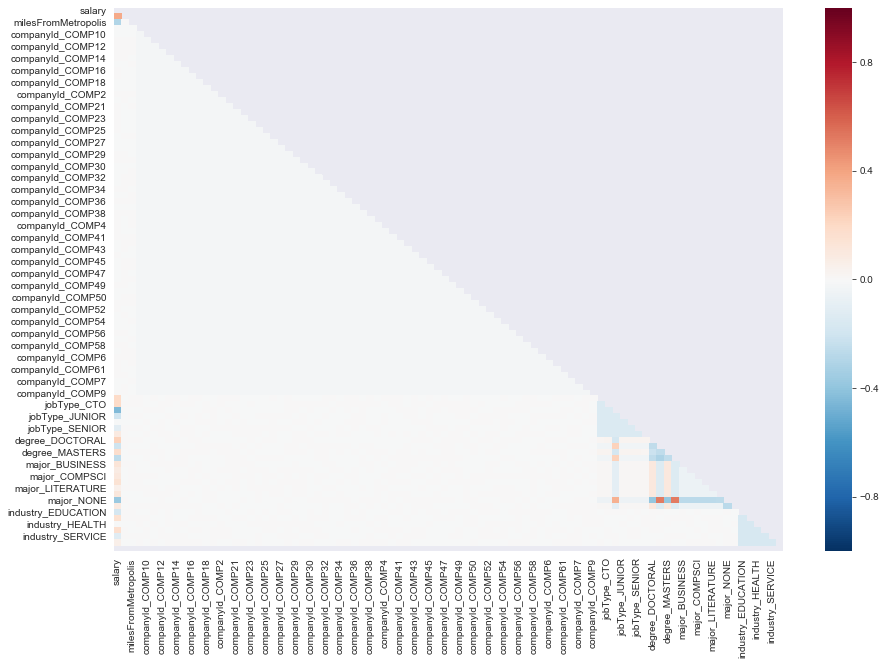

In [90]:
correlations = oh_abt.corr()
plt.figure(figsize=(15,10))

mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = 1

sns.heatmap(correlations,
            mask=mask,
            vmin=-1,
            vmax=1,
           annot=False,
           fmt='.2f',
           cmap='RdBu_r')
plt.ylim(91,0);

This is what is known as the curse of dimensionality! Because there are increased number of columns through this method, and of a feature such as companyId, which doesn't appear to be very influential, there are a large number of features that have no correlation either with the target variable, or each other. There are some pockets of interesting information between the jobType, degree, major and industry though, so perhaps one-hot encoding some of these features in our experimental abt (without the companyId) might be more informative.

#### Label encoding

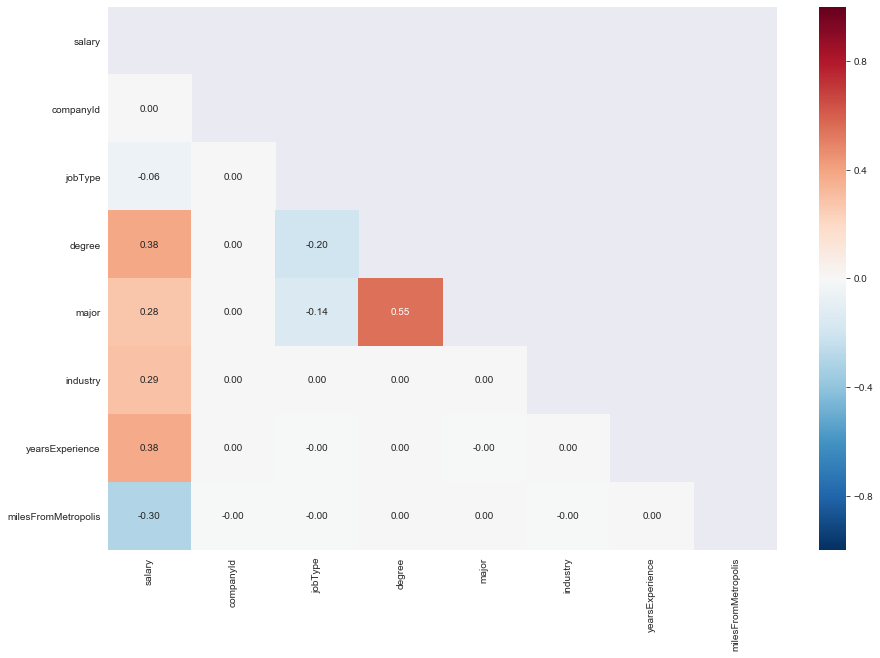

In [106]:
correlations = label_abt.corr()
plt.figure(figsize=(15,10))

mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = 1

sns.heatmap(correlations,
            mask=mask,
            vmin=-1,
            vmax=1,
           annot=True,
           fmt='.2f',
           cmap='RdBu_r')
plt.ylim(8,0)
plt.yticks(rotation=0);

This is so much better – there are fewer irrelevant features and, except for companyID, all the features seem to have some correlation with salary. Few of the features correlate with each other: only a weak correlation between jobType and both degree and major, and a strong correlation between degree and major. A correlation between major and degree is somewhat expected since higher degrees occur more frequently in sciences over humanities subjects and the NONE class is the largest class in the major feature, which is likely to correspond with the NONE/HIGH_SCHOOL degree feature. 
It may still be worth engineering a further education vs high_school or less given the class imbalance.

#### Mean encoding

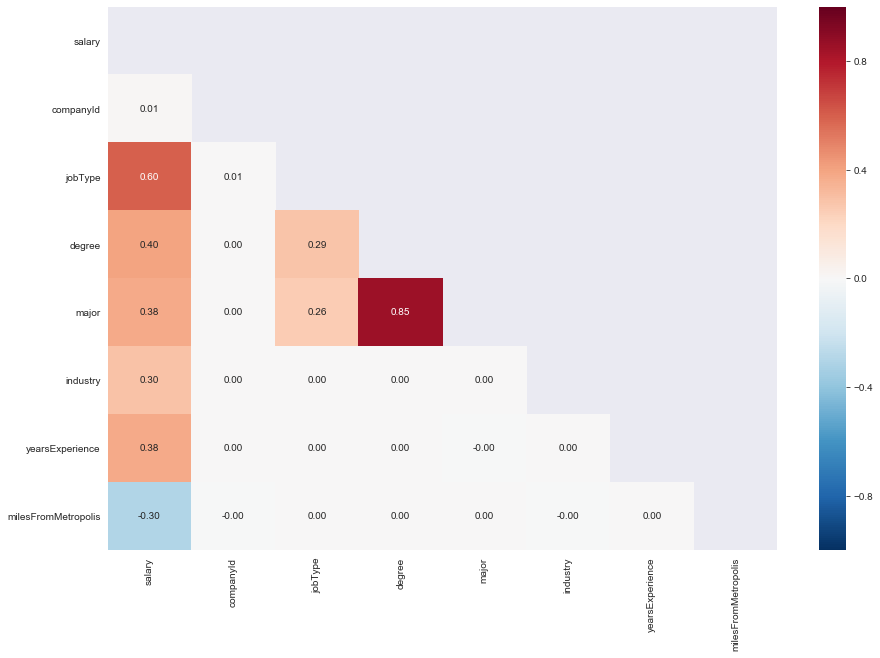

In [94]:
correlations = mean_abt.corr()
plt.figure(figsize=(15,10))

mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = 1

sns.heatmap(correlations,
            mask=mask,
            vmin=-1,
            vmax=1,
           annot=True,
           fmt='.2f',
           cmap='RdBu_r')
plt.ylim(8,0)
plt.yticks(rotation=0);

Using mean encoding, we see stronger correlations between the features and target in this dataset – similar to what we saw with label encoding. Assigning ordinal labels to major and industry (based on the rank of the mean values) and arbitrary labels for companyId might have contributed to this effect. There appears to be no difference in correlation between degree with salary, even with the alternate encoding method, whereas jobType is much improved with mean encoding, and a very strong correlation can be observed between major and degree. 

#### Experimental encoding

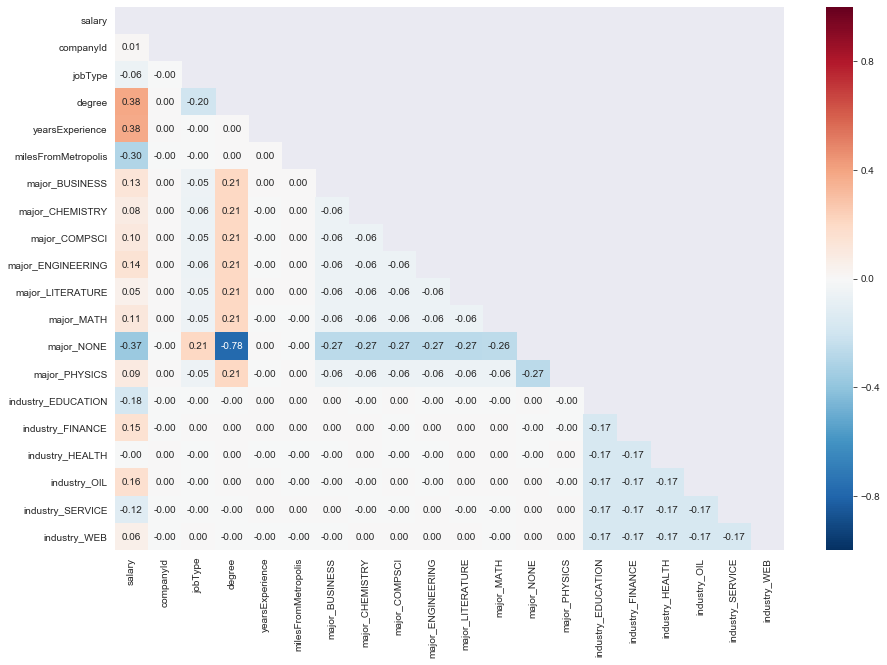

In [100]:
correlations = experimental_abt.corr()
plt.figure(figsize=(15,10))

mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = 1

sns.heatmap(correlations,
            mask=mask,
            vmin=-1,
            vmax=1,
           annot=True,
           fmt='.2f',
           cmap='RdBu_r')
plt.ylim(20,0)
plt.yticks(rotation=0);

Seeing the correlation in this abt is very helpful, and shows some interesting interactions – that most of the correlation seen in the previous correlation tables is between the having no major and no degree. Intuitively this makes sense – I will look into features to address this class imbalance. Additionally, It is interesting to observe the correlation of individual industries and majors with salary.

In [101]:
experimental_oh_abt = pd.get_dummies(train_df, drop_first=True, columns=['degree', 'jobType','major', 'industry'])
mean_encode(experimental_oh_abt, 'companyId')
experimental_oh_abt.head()

,jobId,salary,companyId,yearsExperience,milesFromMetropolis,degree_DOCTORAL,degree_HIGH_SCHOOL,degree_MASTERS,degree_NONE,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,JOB1362684407687,130,115.345049,10,83,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,JOB1362684407688,101,115.756548,3,73,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,JOB1362684407689,137,116.224249,10,38,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,JOB1362684407690,142,116.199380,8,17,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,JOB1362684407691,163,115.888501,8,16,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0


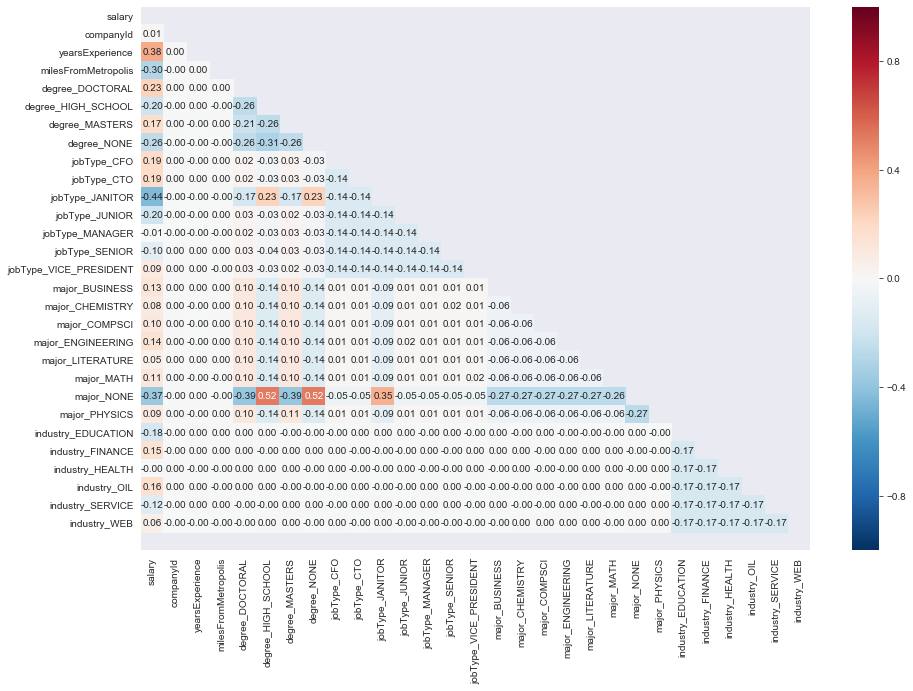

In [103]:
correlations = experimental_oh_abt.corr()
plt.figure(figsize=(15,10))

mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = 1

sns.heatmap(correlations,
            mask=mask,
            vmin=-1,
            vmax=1,
           annot=True,
           fmt='.2f',
           cmap='RdBu_r')
plt.ylim(30,0)
plt.yticks(rotation=0);

Finally, I have encoded one final one_hot encoding oht without the companyId, which was increasing cardinality and introducing too many dimensions to the first base table. Since I have not yet decided on the best model to use, I don't want to limit my options: I will save the base tables of the final three versions here:
    1) mean_encoded abt – this will be my primary table for now. I think it has the possibility of working well in a linear regression models.
    2) experimental_abt – with appropriate regularisation methods (eg, LASSO), this base table could be effective for linear models, but I see potential with tree methods, since the data are more granular.
    3) experimental_oh_abt – as above, but more granular – I'm curious about whether applying PCA to reduce dimensionality would permit granular data in the base table.
    
For the time being I will save these base tables, and move forward with the mean_abt

In [107]:
mean_abt.to_csv('mean_abt.csv', index=None)
experimental_abt.to_csv('experimental_abt.csv', index=None)
experimental_oh_abt.to_csv('experimental_oh_abt.csv', index=None)

### Summary

From looking at all the features in this dataset, we can come to the following conclusions:

   **Salary** - is our target of interest, and is a numeric datatype, therefore a regression model of some kind is likely to be effective. Salary is normally distributed (with a slight skew), with larger deviation at the higher end of the range.
    
   **CompanyId** - has almost no correlation with salary. There is no association with other features.
    
   **Job type** - has the strongest association with salary of all the features, with interaction with degree and major features. This is driven largely by the NONE and HIGH_SCHOOL degree subtypes, which correlate strongly with the JANITOR job type.  
    
   **Degree** – has a strong correlation with salary. Additionally, has a very strong correlation with major. However, this is an imbalanced class, and much of the job listings lie in the NONE or HIGH_SCHOOL subclasses, which seems to drive the major correlation (with NONE major type).        
    
   **Major** – has a strong correlation with salary, like degree, largely driven by the NONE subclass. There is a large imbalance in the distribution of data in this feature.
    
   **Industry** – has a moderate correlation with salary, and low correlation with other features.
    
   **Years experience** – strong linear association with salary, and no interaction with other features. The range of values are a factor of 10 (ish) apart from salary.
    
   **Miles from metropolis** – strong linear association with salary, and no interaction with other features. The range of values is a similar range to salary.
    
Other points to note:
    Job type, degree, and major are not independent features
    Consider using StandardScaler() for all features.    
    

#### Features to be developed
   - I will consider removing **companyId** as a feature during model development, but in the first instance I will retain it in the model to avoid losing data.
   - I will add a binary feature of "Higher_Degree_required", grouping together BACHELORS, MASTERS, and DOCTORAL in the 1 category, and HIGH_SCHOOL, NONE in the 0 category.
   - I will add a "Specialised" binary feature, where a job listing requires a specific degree for the role. Any listing that has a major will be classified as 1, all NONE types will be classified as 0.

### ---- 5 Establish a baseline ----

Baseline MSE: 1367.122950785255


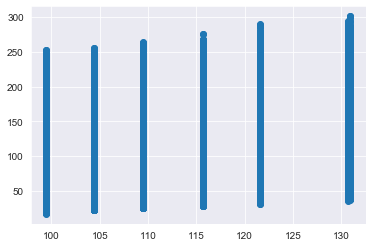

In [126]:
baseline_pred = mean_abt.industry.values
baseline_exp = mean_abt.salary.values

mse = mean_squared_error(baseline_exp, baseline_pred)
plt.scatter(x='industry', y='salary', data=mean_abt);
print('Baseline MSE:', mse)

To yield a more accurate baseline model, I will perform a cross validation on these data:

In [129]:
baseline_regression = LinearRegression().fit(baseline_pred.reshape(-1, 1), baseline_exp)
regression_score = cross_val_score(baseline_regression, baseline_pred.reshape(-1, 1), 
                                   baseline_exp, cv=5, scoring='neg_mean_squared_error')

In [133]:
print('5x cross-validation MSE:', -regression_score.mean())

5x cross-validation MSE: 1367.131582199497


### ---- 6 Hypothesize solution ----

Given the information we have about our data so far, I propose using the following models:

**Linear regression** – given that the years experience and miles from metropolis features are known to be linear, and other features seem to have linear combinations, a linear approach might be suitable for this dataset. However, if I were to end up selecting the abt with one-hot encoding, I would suggest the use of LASSO regularisation to select appropriate features and reduce the dimensionality of the data (and/or use PCA - further work at this point)

**Tree-based regression** – a decision tree would be able to handle categorical data well, and depending on hyperparamaters, could prevent overfitting and has the potential for improved accuracy if the features are not linear – for example, job listings with no degree range from Janitor to CEOs – often homeschooled individuals have an alternative way of thinking and can succeed in an entrepreneurial environment where more studious types do not. A decision tree or random forest algorithm might be better suited to pick up on these deviations from the "norm".

**Gradient-boosting** - ensemble methods such as random forest and gradient boosting can smooth out the granular data from individual trees or regression models. I suspect that these methods might work well, but could also be overkill!